## Prerequisites

In order to use the Azure AI SDK for this workshop we need a the proper Azure resources deployed. This includes
- An Azure AI Search service
- An Azure Storage account containing the data to be indexed by the Azure AI Search service
- An Azure Open AI service with the following models deployed: GPT-4o, ada002 and Dall-E 3.

If the resources are not already deployed, you can execute the cell below. It will create the necessary resources for you and provide you with the necessary information to use in the rest of the workshop. Do mind that you will need to create the vector index in the Azure AI Search service manually, see [the documentation](https://learn.microsoft.com/en-us/azure/search/search-get-started-portal-import-vectors?tabs=sample-data-storage%2Cmodel-aoai#start-the-wizard).


In [ ]:
#!value --from-value @input:"Enter globally unique storage account name" --name $stAccountName
$region = 'swedencentral'
$result = az deployment sub create -l $region -f .\..\deploy\bicep\template.bicep --parameters location=$region rgName=rg-workshop-ai aiSearchSku=standard storageAccountName=$stAccountName | ConvertFrom-Json
az storage blob upload --account-name $stAccountName --container-name assets --name to-analyze.png --file .\..\deploy\assets\to-analyze.png --auth-mode login --overwrite --output none
az storage blob upload --account-name $stAccountName --container-name documents --name go-from-the-beginning.pdf --file .\..\deploy\assets\go-from-the-beginning.pdf --auth-mode login --overwrite --output none
"openAIKey: $($result.properties.outputs.openAiKey.value)"
"azureAISearchKey: $($result.properties.outputs.aiSearchKey.value)"
"azureAIEndpoint: $($result.properties.outputs.aiSearchEndpoint.value)"
"azureAIStudio: $($result.properties.outputs.azureStudioUrl.value)"
"imageUrl : https://$($stAccountName).blob.core.windows.net/assets/to-analyze.png"

If your instructor has already provisioned the resources for you, he or she will provide you with the necessary information to change to cell below to use the existing resources. Otherwise, if you have provisioned the resources using the script in the previous cell you can copy the output of the script and paste it in the proper variables in the cell below.

In [1]:
var openAIKey = "";

var azureAISearchKey = "";
var azureAISearchEndpoint = "";
var azureAISearchIndex = "";

var azureOpenAIEndpoint = "";
var azureOpenAIModelId = "gpt-4o";
var azureOpenAIVisionModelId = "dall-e-3";

var imageUrl = "";

#### Azure Open AI

Azure OpenAI Service provides access to OpenAI's models including the GPT-4, GPT-4 Turbo with Vision, GPT-3.5-Turbo, DALLE-3 and Embeddings model series with the security and enterprise capabilities of Azure.

**Resources:**

- [Azure Open AI](https://learn.microsoft.com/en-us/azure/ai-services/openai/)
- [Microsoft Learn](https://learn.microsoft.com/en-us/dotnet/api/overview/azure/ai.openai-readme)
- [GitHub Repo](https://github.com/Azure/azure-sdk-for-net/blob/main/sdk/openai/Azure.AI.OpenAI/README.md)

### Setting up the client

To use the Azure Open AI api we need to create a client and pass in our credentials. Run the cell below.

In [ ]:
// Tested on Azure.AI.OpenAI, 2.1.0-beta.1
#r "nuget:Azure.AI.OpenAI, *-*" 
#r "nuget:Azure.Identity"

In [4]:
using Azure.AI.OpenAI;
using OpenAI.Chat;
using System.ClientModel;

var client = new AzureOpenAIClient(new Uri(azureOpenAIEndpoint), new ApiKeyCredential(openAIKey));

### Lab 1: Chatting with the AI

The cell below will ask the user to provide a question and it will try to answer it using the GPT-4o model.

In [ ]:
var question = "What is 4+4?";

var chatClient = client.GetChatClient(azureOpenAIModelId);
var completion = await chatClient.CompleteChatAsync(
    [
        new SystemChatMessage("You are a helpful assistant. You will talk like a pirate."),
        new UserChatMessage(question),
    ]);
Console.WriteLine(completion.Value.Content[0].Text);
completion

**Exercises:**

- Inspect the output, what does it provide other than the actual response?
- Ask the AI to add two simple numbers together, what is the answer?
- Ask the AI, after answering the previous question, to add another number, what is the answer? How come?

### Lab 2: Introducing functions

Chatting with the AI is fun, but we can also use it to do some more practical tasks. For that, we might want to reach into a backend system to get some data. In this case, we create a function that shows us the current directory, something that is not possible to do directly with the AI.

Some steps are needed to make this work. First, we need to describe the function so the AI knows what action is performed by the function. Then, we need to provide an implmentation for the function. Finally, we need to register the function with the AI. The steps are outlined below:

```mermaid
sequenceDiagram
    User->>AI: Which directory am I working in?
    AI->>AI: Analyse prompt: should any tool be invoked to answer the question?
    AI->>AI: Select the tool to use based on the tool description
    AI->>C# Function: Execute the tool
    C# Function->>AI: returns "C:\Workshops\AI\"
    AI->>User: Your working directory currently is: ...
```

The cell below creates a function definition and registers it so the AI knows what functions are available to it. Please run the cell now.

In [ ]:
var getCurrentDirectoryTool = ChatTool.CreateFunctionTool(
    functionName: "GetCurrentDirectory",
    functionDescription: "Get the current directory"
);

var options = new ChatCompletionOptions
{
    Tools = { getCurrentDirectoryTool }
};

List<ChatMessage> conversationMessages =
    [
        new UserChatMessage("What's the directory I am working in?"),
    ];
var completion = await chatClient.CompleteChatAsync(conversationMessages, options);
completion

**Excercise:**
- Take a look at the output, inspect the `FinishReason` of the response. What does it say?

Now, the next step is to implement the function. In other words, we need to tell the AI what to do when the function is called. 

Run the cell below.

In [ ]:
static string GetCurrentDirectory()
{
    // This could be anything, like querying a database, or calling a REST API
    return Environment.CurrentDirectory;
}

string GetToolCallContent(ChatToolCall toolCall)
{
    if (toolCall.FunctionName == getCurrentDirectoryTool.FunctionName)
    {
        return GetCurrentDirectory();
    }

    throw new NotImplementedException();
}

Finally, we can ask the AI to give us information about our current directory. When it detects that it needs to run a function to get a correct answer it will call the corresponding tool. Run the cell below.

In [ ]:
var options = new ChatCompletionOptions
{
    Tools = { getCurrentDirectoryTool }
};

List<ChatMessage> conversationMessages =
    [
        new UserChatMessage("What's the directory I am working in?"),
    ];
var completion = await chatClient.CompleteChatAsync(conversationMessages, options);
if (completion.Value.FinishReason == ChatFinishReason.ToolCalls)
{
    // Add a new assistant message to the conversation history that includes the tool calls
    conversationMessages.Add(new AssistantChatMessage(completion));

    foreach (ChatToolCall toolCall in completion.Value.ToolCalls)
    {
        conversationMessages.Add(new ToolChatMessage(toolCall.Id, GetToolCallContent(toolCall)));
    }
}
completion = await chatClient.CompleteChatAsync(conversationMessages, options);
Console.WriteLine(completion.Value.Content[0].Text);
completion

Now, when it comes to functions it is better to create several smaller chatbots that can answer specific questions for a specific domain than having one chatbot that has tens of functions. This way the AI can better understand the context and provide better answers. To orchestrate more complex flows an orchestrating chatbot could determine the intent and delegate the task to a specialized chatbot. In AI terms these kind of chatbots are called agents.

In this notebook we are only exploring the basic OpenAI SDK. For more complex scenarios one can use [Semantic Kernel](https://learn.microsoft.com/en-us/semantic-kernel/overview/?tabs=Csharp) or [LangChain](https://www.langchain.com/).

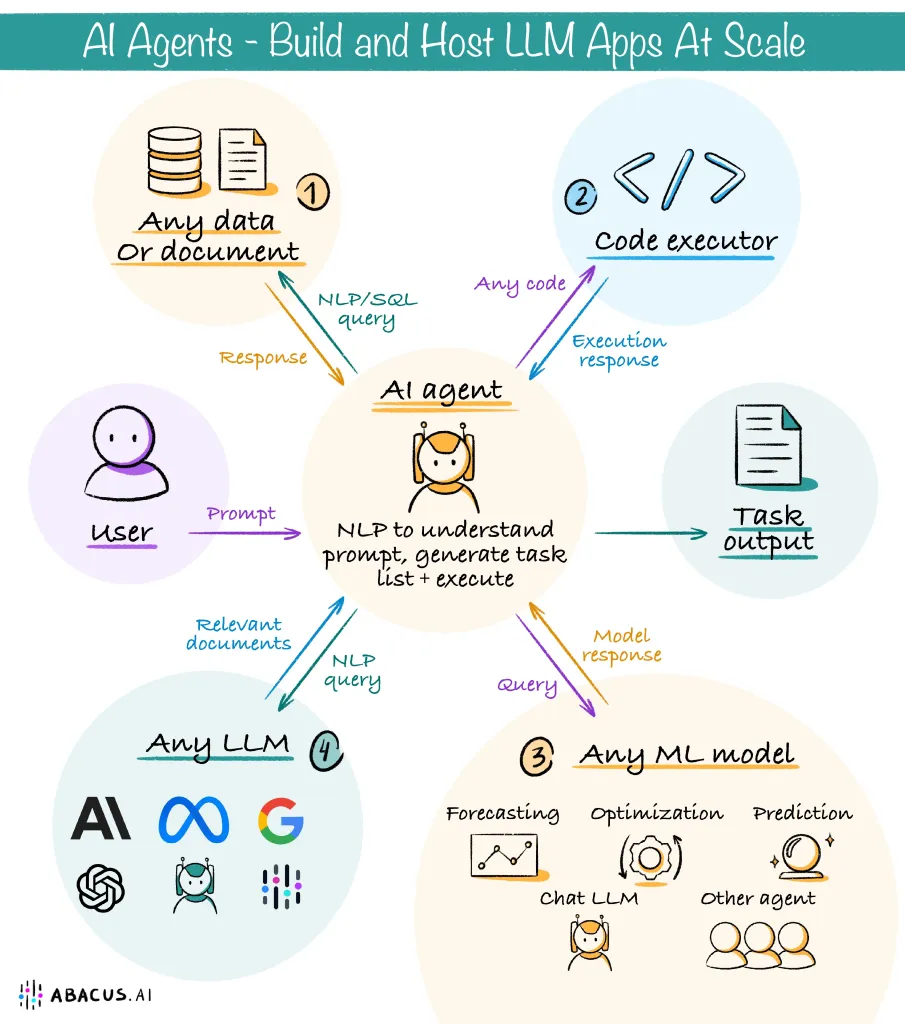

**Questions:**

- What possibilities do you see with this kind of technology for our organization?
- What needs to be done to make this a reality?
- What are the risks of using this technology?

### Lab 3: Chat with your data

In information retrieval, Retrieval Augmented Generation (RAG) is an approach that enables you to harness the power of LLMs with your own data. Enabling an LLM to access custom data involves the following steps. First, the large data should be chunked into manageable pieces. Second, the chunks need to be converted into a searchable format. Third, the converted data should be stored in a location that allows efficient access. Additionally, it's important to store relevant metadata for citations or references when the LLM provides responses.

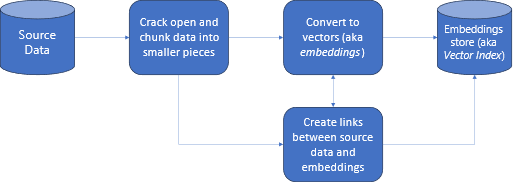

It is important to note that an embedding is created from the user prompt as well so a similarity score can be calculated between the prompt and the data. This is done to ensure that the data retrieved is relevant to the user's question.

When using Azure, [Azure AI Search](https://learn.microsoft.com/en-us/azure/search/search-what-is-azure-search) can take care of cracking open documents, chunking them, and creating embeddings stored in Azure AI Search. By using indexers new and updated documents will be processed periodically as well. 

It is important to note that the documents content is stored twice, once in its formal location and once in Azure AI Search.

We have already provisioned a search service for you. The cell below will allow you to interact with the search service using the OpenAI SDK.

In [ ]:
using Azure.AI.OpenAI.Chat;

#pragma warning disable AOAI001

var options = new ChatCompletionOptions();
options.AddDataSource(new AzureSearchChatDataSource()
{
    Endpoint = new Uri(azureAISearchEndpoint),
    IndexName = azureAISearchIndex,
    Authentication = DataSourceAuthentication.FromApiKey(azureAISearchKey),
});

var question = "What is the main benefit of function programming?"; 
// Or try one of the following questions:
// "What is the main benefit of function programming?"
// "I have trouble focusing on my work. Can you help me?"
// "Do you have some tips on how to improve a learning culture in my company"
// "What books are you aware of?"
var completion = await chatClient.CompleteChatAsync(
    [
        new UserChatMessage(question),
    ], options);

ChatMessageContext onYourDataContext = completion.Value.GetMessageContext();
Console.WriteLine(completion.Value.Content[0].Text);
completion.Display();
onYourDataContext


### Lab 4: Generate an image

The AI can also generate images. In this case we ask the AI to generate an image of a monkey. Run the cell below.

In [ ]:
var imageClient = client.GetImageClient(azureOpenAIVisionModelId);
var result = await imageClient.GenerateImageAsync("A monkey furiously typing code on a laptop in an office in a lush green forest.");
Console.WriteLine(result.Value.ImageUri);    
result    

Did you notice whe are using a different model here? Some AI models are suited for image generation, others are suited to analyse images or generate or analyze text. The Azure AI SDK provides access to a wide range of models. Some models, like GTP-4o, are more general purpose and can be used for a wide range of tasks (across text, vision, and audio). These models are so-called multimodels.

Most image generation models do have a limited resolution. This is because the model needs to generate a lot of data and the more data the model needs to generate the more complex the model needs to be. Typically another step would be to use an AI model that can upscale the image to a higher resolution.

**Question**
- Compare your image against one of the other participants. What are the differences? What does this mean?
- What could be a use case for this kind of technology?

### Lab 5: Chat with images

AI can not only be used to generate images, but also to analyze them. If we feed the model with the previous generated image it will probably tell it will see a monkey sitting in an office in the jungle. Lets try to see what the model does with a more advanced question.

Please take a look at the following image, then run the cell below.

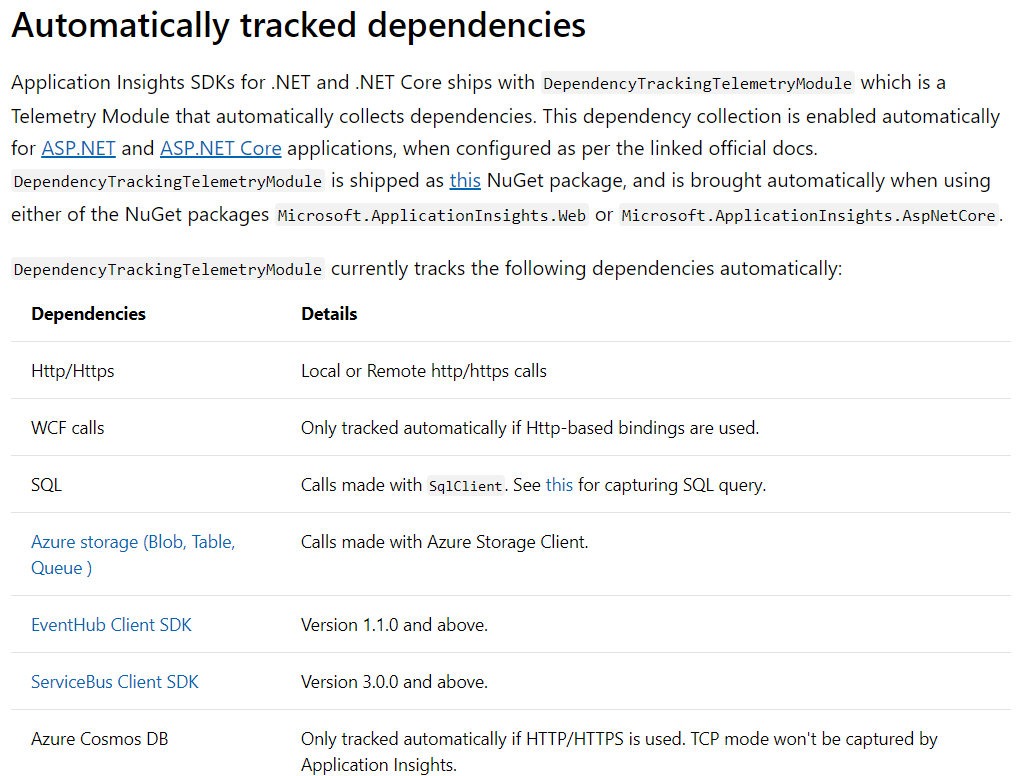

In [ ]:
var chatClient = client.GetChatClient(azureOpenAIModelId);
var completion = await chatClient.CompleteChatAsync(
    [
        new SystemChatMessage("You are a helpful assistant that describes images."),
        new UserChatMessage(ChatMessageContentPart.CreateImagePart(new Uri(imageUrl))),
        new UserChatMessage("Hi, please tell me, are WCF calls automatically tracked in Application Insights?")
    ]);
Console.WriteLine(completion.Value.Content[0].Text);
completion

**Question**
- Can you think of any use case for this scenario?

### Lab 6: Introducing Assistants

Open AI has this concept called *Assistants*. Assistants are trained to assist users in a specific domain. For example, there is an assistant that can help you with your code, another one that can help you with your writing, and another one that can help you with your math. Assistant can use tools to help them answer questions, like the function we created earlier, or a code tool.

As we have discovered in Lab 1, the AI is stateless. This means that the AI does not remember the previous questions or answers. This is where Assistants come in. They can remember the context of the conversation and use it to provide better answers. They take away the effort of having to maintain state.

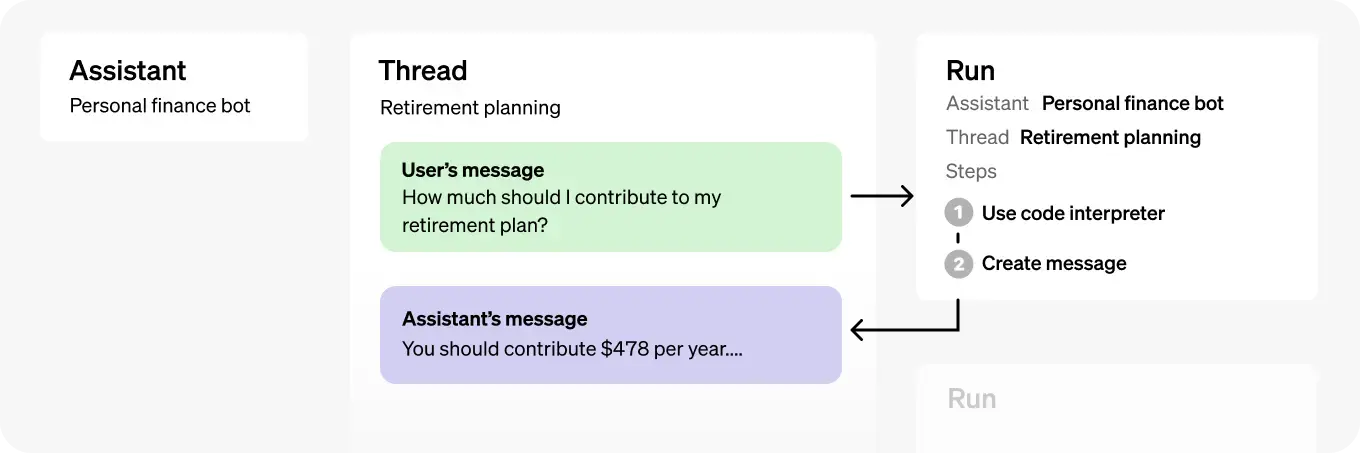

Run the cell below to create an assistant.

In [ ]:
#pragma warning disable OPENAI001

using Azure;
using Azure.AI.OpenAI;
using OpenAI.Assistants;

var assistantClient = client.GetAssistantClient();

var assistant = await assistantClient.CreateAssistantAsync(
    azureOpenAIModelId,
    new AssistantCreationOptions()
    {
        Name = "My Friendly Math Assistant",
        Instructions = "You politely help with math questions.",
    });

Once we have access to an assistant we can ask it questions. First, we need to create a thread, a conversation session between an Assistant and a user. Threads store Messages and automatically handle truncation to fit content into a model’s context. Messages can include text, images, and other files. Messages stored as a list on the Thread.

When we have created a thread and added messages to it we create a Run, an invocation of an Assistant on a Thread. The Assistant uses its configuration and the Thread’s Messages to perform tasks by calling models and tools. As part of a Run, the Assistant appends Messages to the Thread.

When the Run is finished, we can inspect the messages to see the output of the Assistant. Run the cell below to create a thread and run the assistant.

In [ ]:
#pragma warning disable OPENAI001

var thread = await assistantClient.CreateThreadAsync();
var message = await assistantClient.CreateMessageAsync(thread.Value.Id, MessageRole.User, new[] { MessageContent.FromText("What is 4 + 4?") });
var run = await assistantClient.CreateRunAsync(thread.Value.Id, assistant.Value.Id);

do{
    await Task.Delay(200);
    run = await assistantClient.GetRunAsync(thread.Value.Id, run.Value.Id);
}
while(run.Value.Status == RunStatus.Queued || run.Value.Status == RunStatus.InProgress);

var runResult = assistantClient.GetMessagesAsync(thread.Value.Id);
await foreach(var message in runResult)
{
    Console.WriteLine(string.Join(Environment.NewLine, message.Content.Select(c=> c.Text)));
}

Now, if we want to continue the conversation we can create a new Run. 

Run the cell below to continue the conversation.

In [ ]:
#pragma warning disable OPENAI001

var message = await assistantClient.CreateMessageAsync(thread.Value.Id, MessageRole.User, new[] { MessageContent.FromText("What is 2 * the previous answer?") });
var run = await assistantClient.CreateRunAsync(thread.Value.Id, assistant.Value.Id);

do{
    await Task.Delay(200);
    run = await assistantClient.GetRunAsync(thread.Value.Id, run.Value.Id);
}
while(run.Value.Status == RunStatus.Queued || run.Value.Status == RunStatus.InProgress);

var runResult = assistantClient.GetMessagesAsync(thread.Value.Id);
await foreach(var message in runResult)
{
    Console.WriteLine(string.Join(Environment.NewLine, message.Content.Select(c=> c.Text)));
}

As you can see you can have a conversation with the AI and it will remember the context of the conversation. With assistants we can have ongoing conversations about specific topics, images or files.

Now, since we have introduced state that is automatically stored and managed, including any files or images that are part of the conversation, we should delete the thread and assistant once we are done completely

In [ ]:
await assistantClient.DeleteThreadAsync(thread.Value.Id);
await assistantClient.DeleteAssistantAsync(assistant.Value.Id);

### Lab 7: Using Assistants to chat with files

Assistants are more that just a chatbot with history. They can also interact with audio & video and images and they can use tools to perform tasks like writing code to answer a question. In this lab we will use an assistant to chat with a file. We will upload a file to the assistant and ask it a question about the books content.

Since assistants can remember the context of the conversation and the uploads are stored in a vector database we can build powerful assistants that can help us with a wide range of tasks.

The cell below will create an assistant that can help us with the book. Run the cell now.

In [ ]:
#pragma warning disable OPENAI001

using OpenAI.Files;

var fileClient = client.GetOpenAIFileClient();
var vectorStoreClient = client.GetVectorStoreClient();
var assistantClient = client.GetAssistantClient();

var uploadResult = await fileClient.UploadFileAsync(@"..\deploy\assets\go-from-the-beginning.pdf", FileUploadPurpose.Assistants);

var assistant = await assistantClient.CreateAssistantAsync(
    azureOpenAIModelId,
    new AssistantCreationOptions()
    {
        Tools = { new FileSearchToolDefinition() },
        ToolResources = new()
        {
            FileSearch = new()
            {
                NewVectorStores = { new VectorStoreCreationHelper([uploadResult.Value.Id]) }
            }
        }
    }
);

A vector store can be bound to one assistant but can contain multiple files. The assistant can then use the vector store to retrieve the file that is most relevant to the question asked. 

Now that the file is uploaded and vectorized we can ask the assistant a question about the book. Run the cell below.

In [ ]:
#pragma warning disable OPENAI001

ThreadCreationOptions threadOptions = new()
{
    InitialMessages = { "What are go coroutines?" }
};

ThreadRun threadRun = assistantClient.CreateThreadAndRun(assistant.Value.Id, threadOptions);
do
{
    await Task.Delay(TimeSpan.FromSeconds(1));
    threadRun = assistantClient.GetRun(threadRun.ThreadId, threadRun.Id);
} while (!threadRun.Status.IsTerminal);

After the run we can fetch the messages to see the output of the assistant. Output can be mix of text messages, images and annotations.  Run the cell below and inspect the output. Can you see how the assistant has used the file to answer the question?

In [ ]:
#pragma warning disable OPENAI001

var messages = assistantClient.GetMessages(threadRun.ThreadId, new MessageCollectionOptions() 
    { Order = MessageCollectionOrder.Ascending });

foreach (ThreadMessage message in messages)
{
    Console.Write($"[{message.Role.ToString().ToUpper()}]: ");
    foreach (MessageContent contentItem in message.Content)
    {
        if (!string.IsNullOrEmpty(contentItem.Text))
        {
            Console.WriteLine($"{contentItem.Text}");

            foreach (TextAnnotation annotation in contentItem.TextAnnotations)
            {
                annotation.Display();
            }
        }
    }
    Console.WriteLine();
}

The final taks is to delete the assistant and the vector store. Run the cell below to delete the assistant and the vector store.

In [ ]:
await assistantClient.DeleteThreadAsync(thread.Value.Id);
await assistantClient.DeleteAssistantAsync(assistant.Value.Id);
await vectorStoreClient.DeleteVectorStoreAsync(assistant.Value.ToolResources.FileSearch.VectorStoreIds.First());

### Conclusion

In this notebook we have seen how to use the Azure AI SDK to chat with the AI, create functions, chat with data, generate images and chat with images. We have seen that the AI can be used for a wide range of tasks and that it can be used to automate a lot of tasks. However, we have also seen that the AI is not perfect and that it can make mistakes. It is important to understand the limitations of the AI and to use it in a responsible way.

There are still a lot of capabilities we did not demo here, for example: 
- analyzing and creating video
- analyzing and creating audio
- using the AI to generate code in order to answer a question

**Question**
- Can you think of any use case for these audio and video capabilities applied to our organization?

If you are interested in these capabilities you can find more information in the [Azure AI documentation](https://learn.microsoft.com/en-us/azure/ai-services/multi-service-resource?tabs=windows&pivots=azportal).